In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import pylab as plt
from scipy.stats import percentileofscore

In [2]:
data_path = '/media/bigdata/firing_space_plot/firing_analyses/transition_corrs/all_tastes/sig_corr_var_data.json'
sig_cor_var_frame = pd.read_json(data_path)

In [3]:
x = sig_cor_var_frame['var']
y = sig_cor_var_frame['corr']
y = y - y.min()
y = y / y.max()
x = x - x.min()
x = x / x.max()

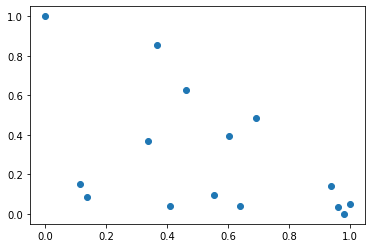

In [4]:
plt.scatter(x,y)

## Model with constant noise

In [114]:
with pm.Model() as model:
    slope = pm.Normal('slope', mu = 0, sigma = 10)
    intercept = pm.Normal('intercept', mu = 0, sigma = 1)
    noise = pm.HalfNormal('noise', sigma = 1)
    
    obs = pm.Normal('obs', mu = intercept + (slope*x), sigma = noise, observed=y)
    #obs = pm.TruncatedNormal('obs', mu = intercept + (slope*x), sigma = noise, lower=0, upper=100, observed=y)

In [115]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7127909109138997, but should be close to 0.8. Try to increase the number of tuning steps.


In [116]:
trace = trace[::10]
#pm.autocorrplot(trace);

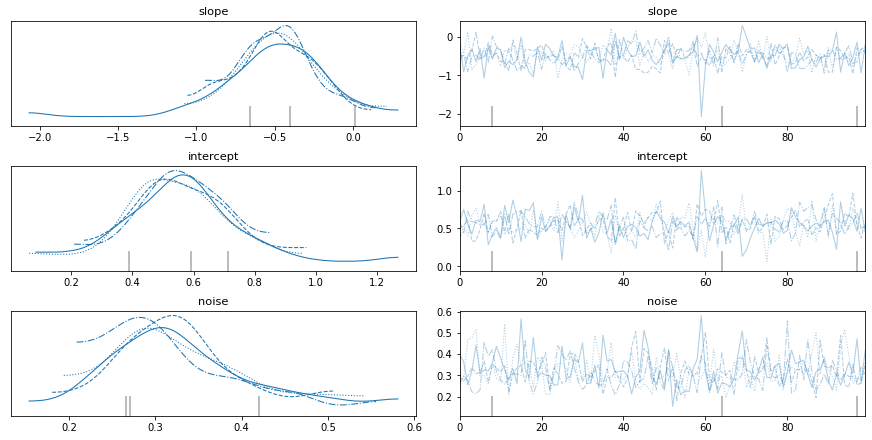

In [117]:
with model:
    pm.traceplot(trace)

Text(0.5, 0.98, 'Distribution of Slope')

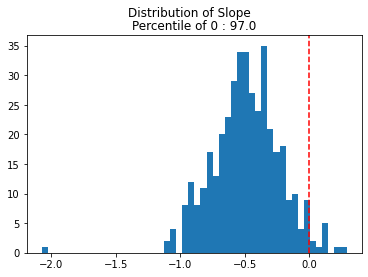

In [118]:
perc0 = percentileofscore(trace['slope'],0)
plt.hist(trace['slope'], bins = 50);
plt.axvline(0, color = 'red', linestyle = '--')
plt.title(f'Percentile of 0 : {perc0}');
plt.suptitle('Distribution of Slope')

In [119]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names = ['obs'])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


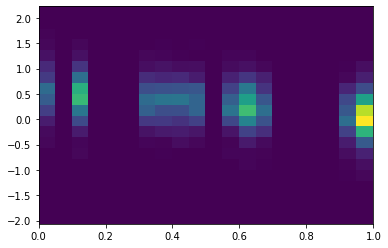

In [120]:
x_large = np.broadcast_to(x[np.newaxis,:], ppc['obs'].shape)
#plt.scatter(x_large,ppc['obs'], alpha = 0.1)
plt.hist2d(x_large.flatten(),ppc['obs'].flatten(),bins=20);

In [121]:
# Generate some lines
count = 100
slopes = trace['slope'][:count][np.newaxis,:]
intercepts = trace['intercept'][:count][np.newaxis,:]

x_lin = np.linspace(x.min(),x.max())[:,np.newaxis]

(-0.1, 1.1)

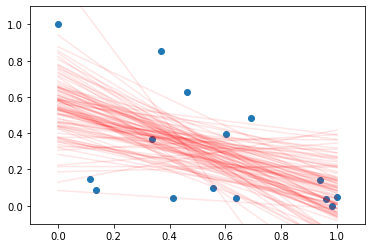

In [144]:
plt.plot(x_lin, np.dot(x_lin, slopes) + intercepts, color = 'red', alpha = 0.1);
plt.scatter(x,y)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

## Model with x-related noise

In [19]:
with pm.Model() as model:
    slope = pm.Normal('slope', mu = 0, sigma = 10)
    intercept = pm.Normal('intercept', mu = 0, sigma = 1)
    
    noise_slope = pm.Normal('noise_slope', mu = 0, sigma = 10)
    noise_intercept = pm.Normal('noise_intercept', mu = 0, sigma = 1)  
    #noise_line = pm.Deterministic('noise_line',noise_intercept + (noise_slope*x))
    noise_line_pos = pm.Deterministic('noise_line_pos',
                                      pm.math.log(1+\
                                      pm.math.exp(noise_intercept + (noise_slope*x))
                                     ))
    #noise_line_pos = pm.Deterministic('noise_line_pos', pm.math.switch(noise_line<0.1, 0.1, noise_line))
    noise = pm.HalfNormal('noise', sigma = noise_line_pos, shape = x.shape)
    
    #obs = pm.Normal('obs', mu = intercept + (slope*x), sigma = noise, observed=y)
    obs = pm.TruncatedNormal('obs', mu = intercept + (slope*x), sigma = noise, lower=0, upper=100, observed=y)

In [20]:
with model:
    #trace = pm.sample(draws = 5000)
    trace = pm.sample(draws = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, noise_intercept, noise_slope, intercept, slope]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
There were 4709 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6279976070244123, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4871 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.48104503039000845, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4684 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4905 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6045400239061246, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems dur

In [21]:
trace = trace[::10]

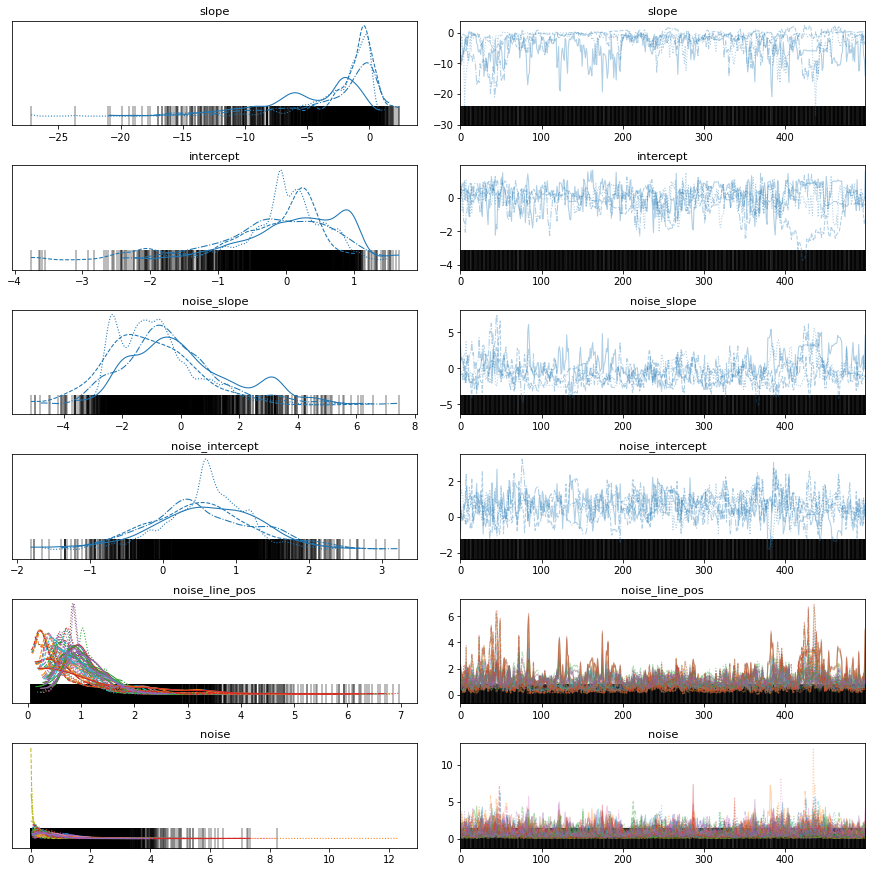

In [22]:
with model:
    pm.traceplot(trace)

In [23]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names = ['obs'])

Text(0.5, 0.98, 'Distribution of Slope')

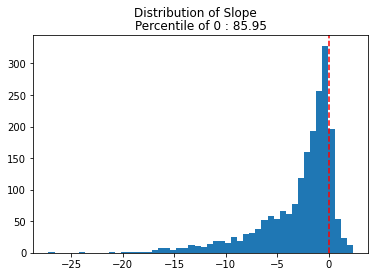

In [24]:
perc0 = percentileofscore(trace['slope'],0)
plt.hist(trace['slope'], bins = 50);
plt.axvline(0, color = 'red', linestyle = '--')
plt.title(f'Percentile of 0 : {perc0}');
plt.suptitle('Distribution of Slope')

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


(0.0, 1.0)

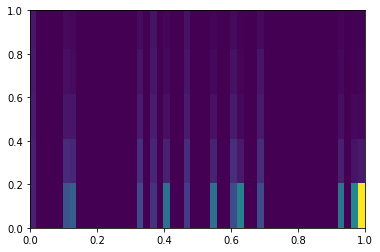

In [31]:
x_large = np.broadcast_to(x[np.newaxis,:], ppc['obs'].shape)
#plt.scatter(x_large,ppc['obs'], alpha = 0.01)
plt.hist2d(x_large.flatten(),ppc['obs'].flatten(),bins=50);
plt.ylim(0,1)